<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/heirarchical_binomial_baseball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings('ignore')

!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 16.6MB/s 
     |████████████████████████████████| 286kB 15.7MB/s 
     |████████████████████████████████| 911kB 2.8MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [3]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch09-heirarchical-models'

Cloning into 'data-science-hw'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 205 (delta 96), reused 44 (delta 13), pack-reused 0
Receiving objects: 100% (205/205), 7.60 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [10]:
consolidated = pd.read_csv(base_path+'/BattingAverage.csv')
consolidated.drop(columns=['Player', 'PriPos'], inplace=True)
consolidated.rename(columns={'Hits': 'successes', 'AtBats': 'attempts', 'PlayerNumber': 'individual_id', 'PriPosNumber': 'category_id'}, inplace=True)

min_category_id = np.min(consolidated['category_id'])
min_individual_id = np.min(consolidated['individual_id'])

consolidated['category_id'] = consolidated['category_id'] - min_category_id
consolidated['individual_id'] = consolidated['individual_id'] - min_individual_id
consolidated.head()


,successes,attempts,individual_id,category_id
0,1,7,0,0
1,53,219,1,6
2,18,70,2,3
3,137,607,3,3
4,21,86,4,2


In [11]:
num_individuals = len(consolidated)
num_categories = len(np.unique(consolidated['category_id']))

print('num_individuals', num_individuals, 'num_categories', num_categories)

individual_id = consolidated['individual_id']
category_id = consolidated['category_id']


num_individuals 948 num_categories 9


## No Heirarchy - Individuals

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:21<00:00, 115.07it/s]


                    mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_individual[0]    0.221  0.130   0.015  ...    7279.0    2082.0    1.0
p_individual[1]    0.244  0.029   0.190  ...    9077.0    2617.0    1.0
p_individual[2]    0.264  0.051   0.174  ...    9032.0    2845.0    1.0
p_individual[3]    0.226  0.017   0.194  ...    9286.0    2875.0    1.0
p_individual[4]    0.250  0.044   0.171  ...    7278.0    2234.0    1.0
...                  ...    ...     ...  ...       ...       ...    ...
p_individual[943]  0.334  0.178   0.045  ...    7418.0    2586.0    1.0
p_individual[944]  0.283  0.019   0.247  ...    8309.0    2865.0    1.0
p_individual[945]  0.204  0.052   0.111  ...    9923.0    2703.0    1.0
p_individual[946]  0.091  0.039   0.027  ...    5891.0    2350.0    1.0
p_individual[947]  0.270  0.018   0.237  ...    7334.0    2624.0    1.0

[948 rows x 11 columns]


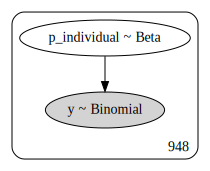

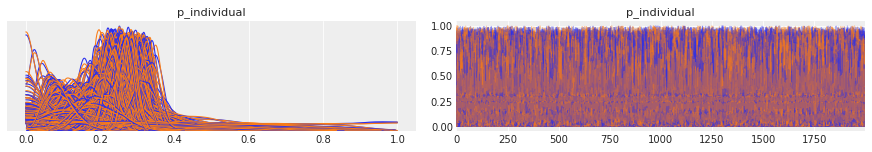

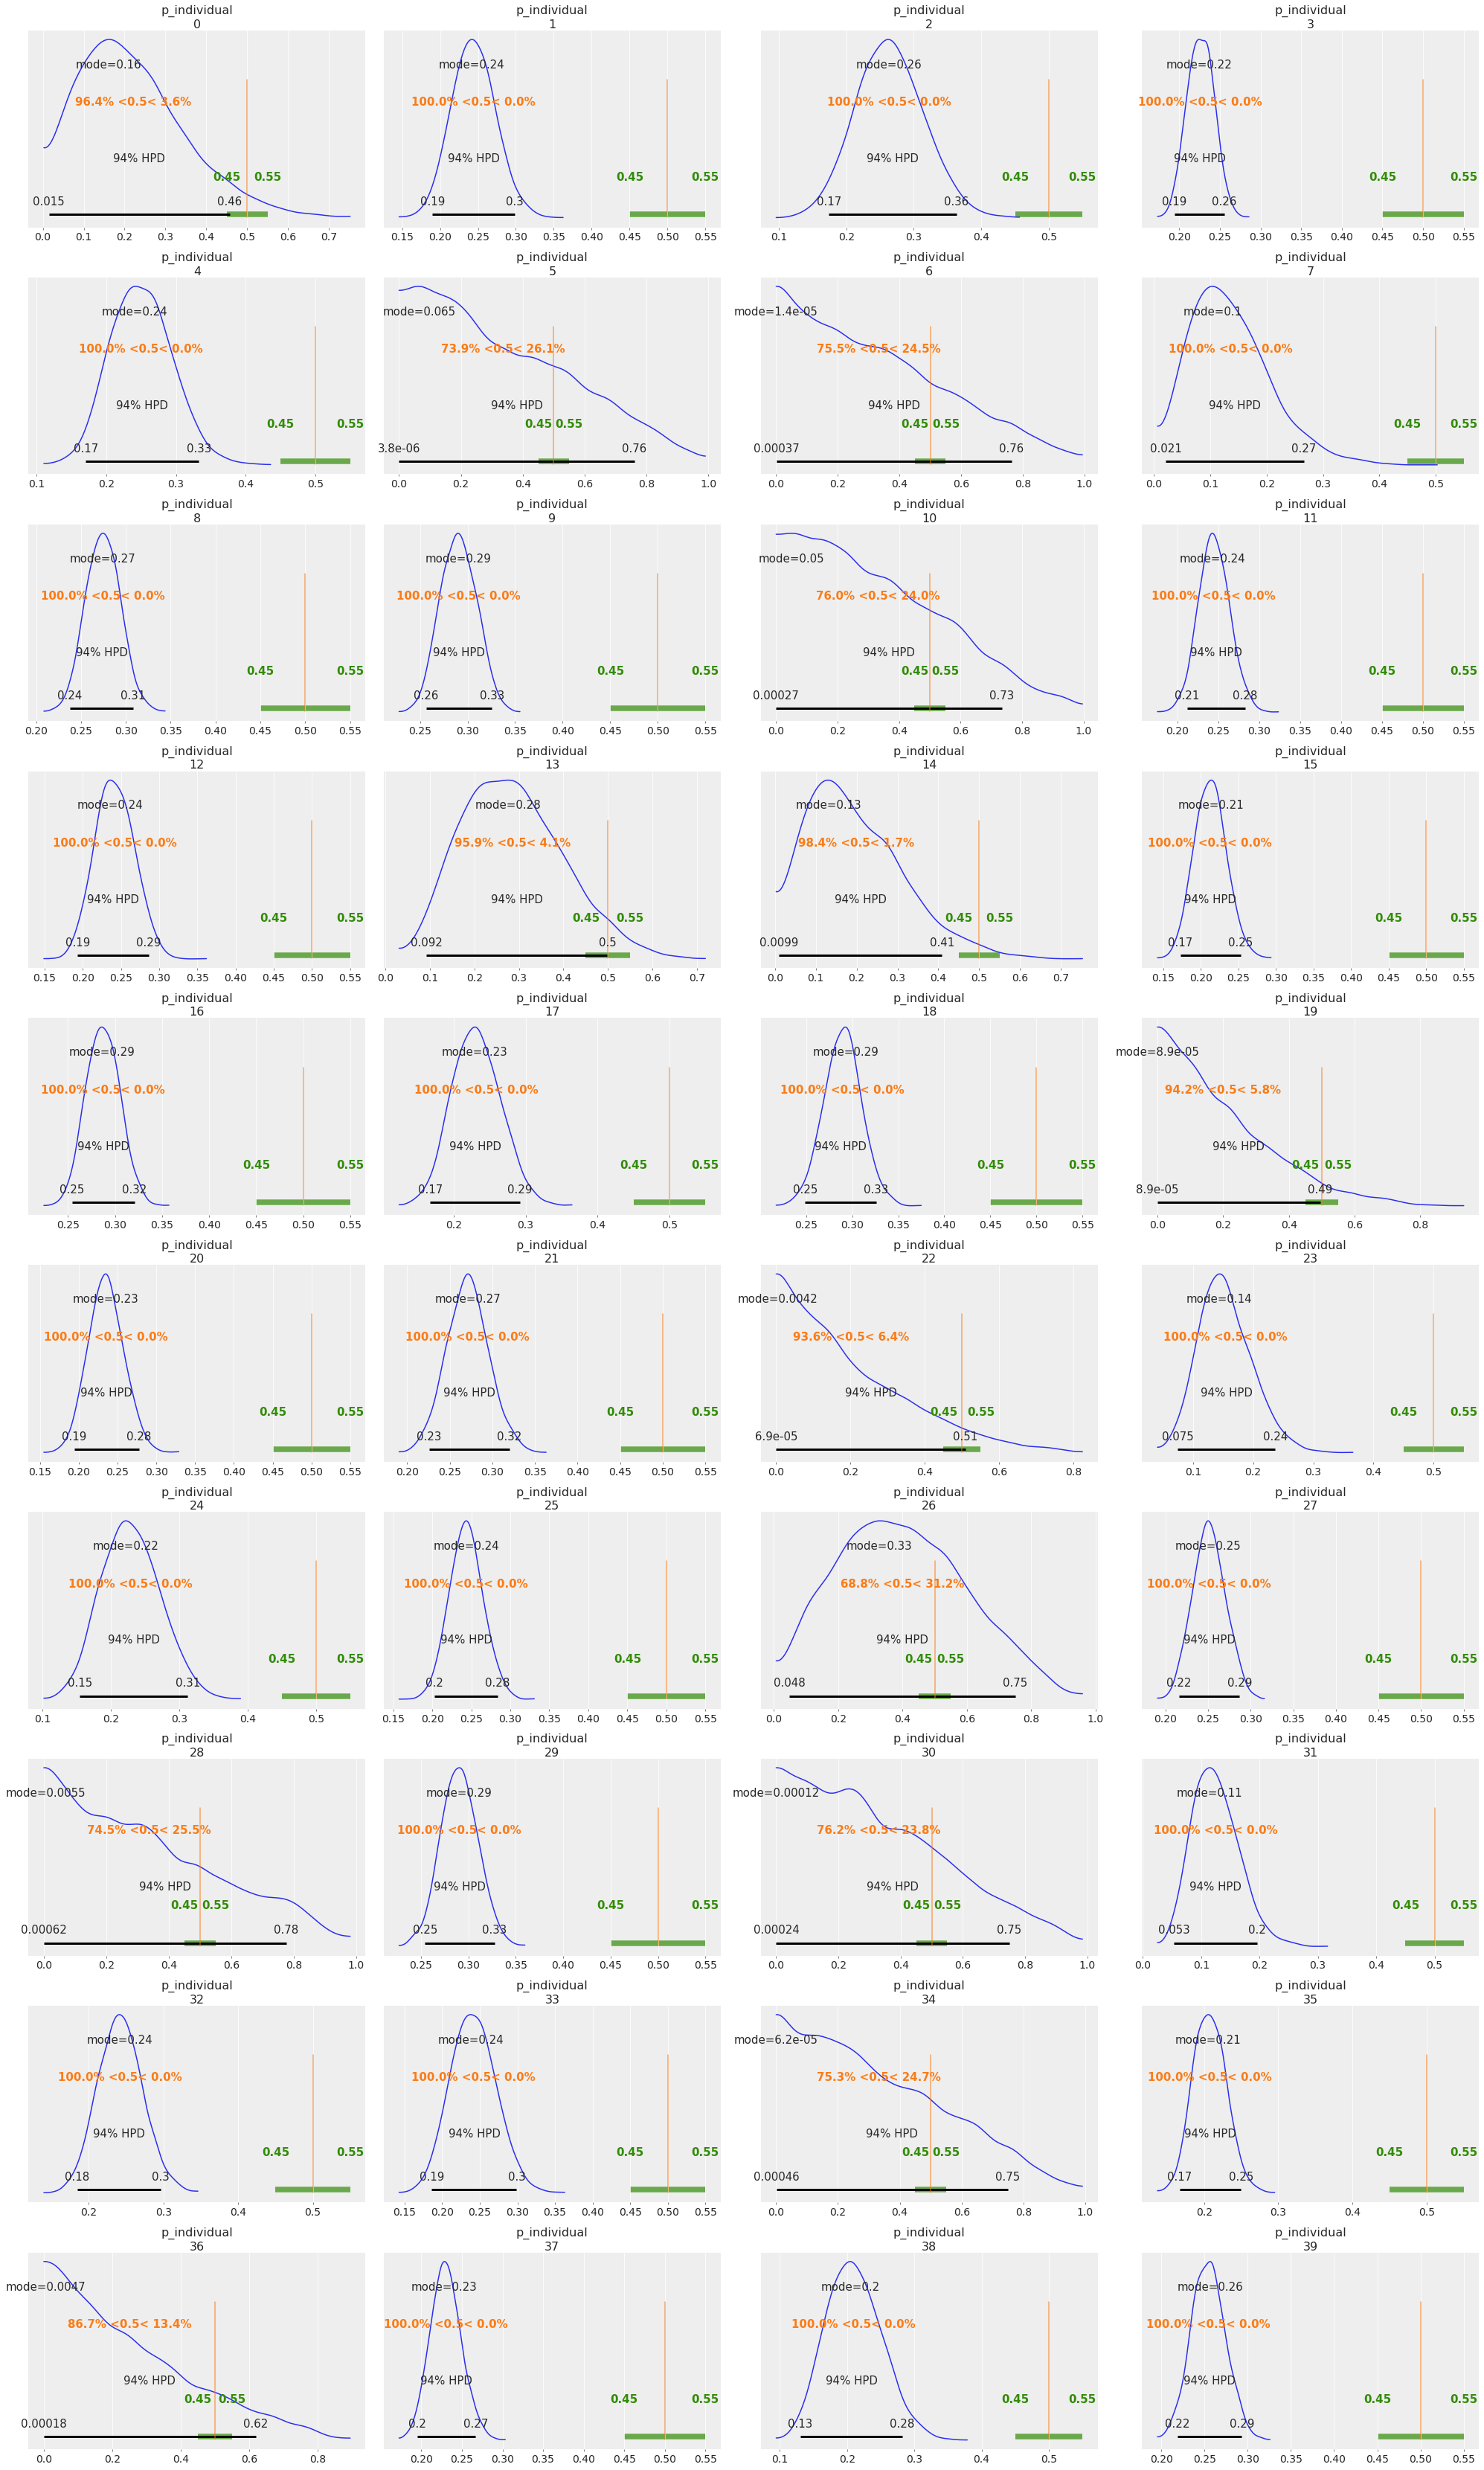

In [12]:
with pm.Model() as model_nh:
  p_individual = pm.Beta('p_individual', alpha=1., beta=1., shape=num_individuals)   # uniform prior
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_nh = pm.sample(2000, random_seed=123)
  print(az.summary(trace_nh))
  pm.traceplot(trace_nh)
  az.plot_posterior(trace_nh, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_nh)

## Heirarchy - No Overall


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual, concentration_category, p_category]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:59<00:00, 42.28it/s]
The number of effective samples is smaller than 25% for some parameters.


                    mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_category[0]      0.130  0.007   0.119  ...    1189.0    1943.0    1.0
p_category[1]      0.239  0.008   0.225  ...    4156.0    3164.0    1.0
p_category[2]      0.253  0.008   0.238  ...    5214.0    3142.0    1.0
p_category[3]      0.249  0.009   0.233  ...    4115.0    3165.0    1.0
p_category[4]      0.255  0.009   0.238  ...    4827.0    3127.0    1.0
...                  ...    ...     ...  ...       ...       ...    ...
p_individual[943]  0.143  0.056   0.049  ...    6963.0    2645.0    1.0
p_individual[944]  0.280  0.018   0.246  ...    7941.0    2699.0    1.0
p_individual[945]  0.169  0.038   0.101  ...    6235.0    2685.0    1.0
p_individual[946]  0.097  0.031   0.039  ...    6782.0    2578.0    1.0
p_individual[947]  0.269  0.018   0.235  ...    7841.0    2638.0    1.0

[966 rows x 11 columns]


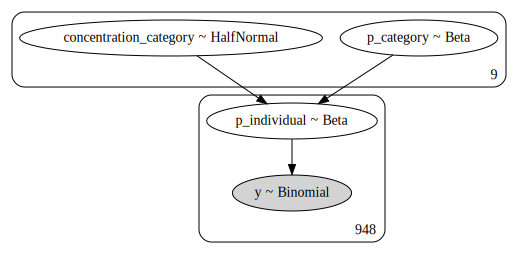

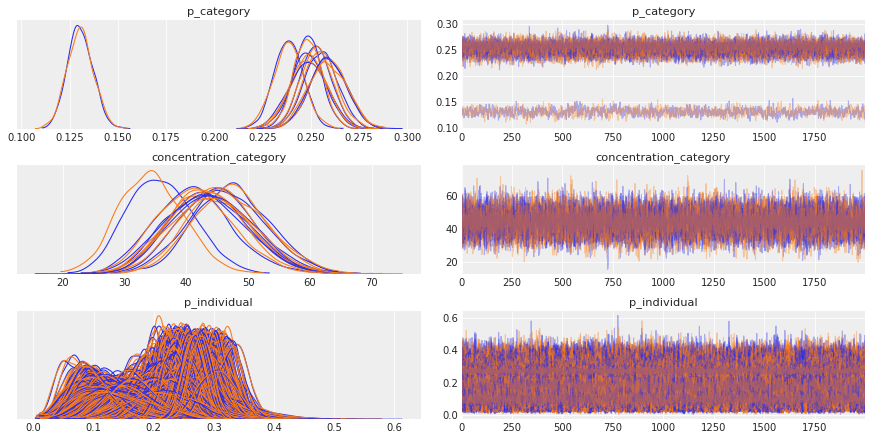

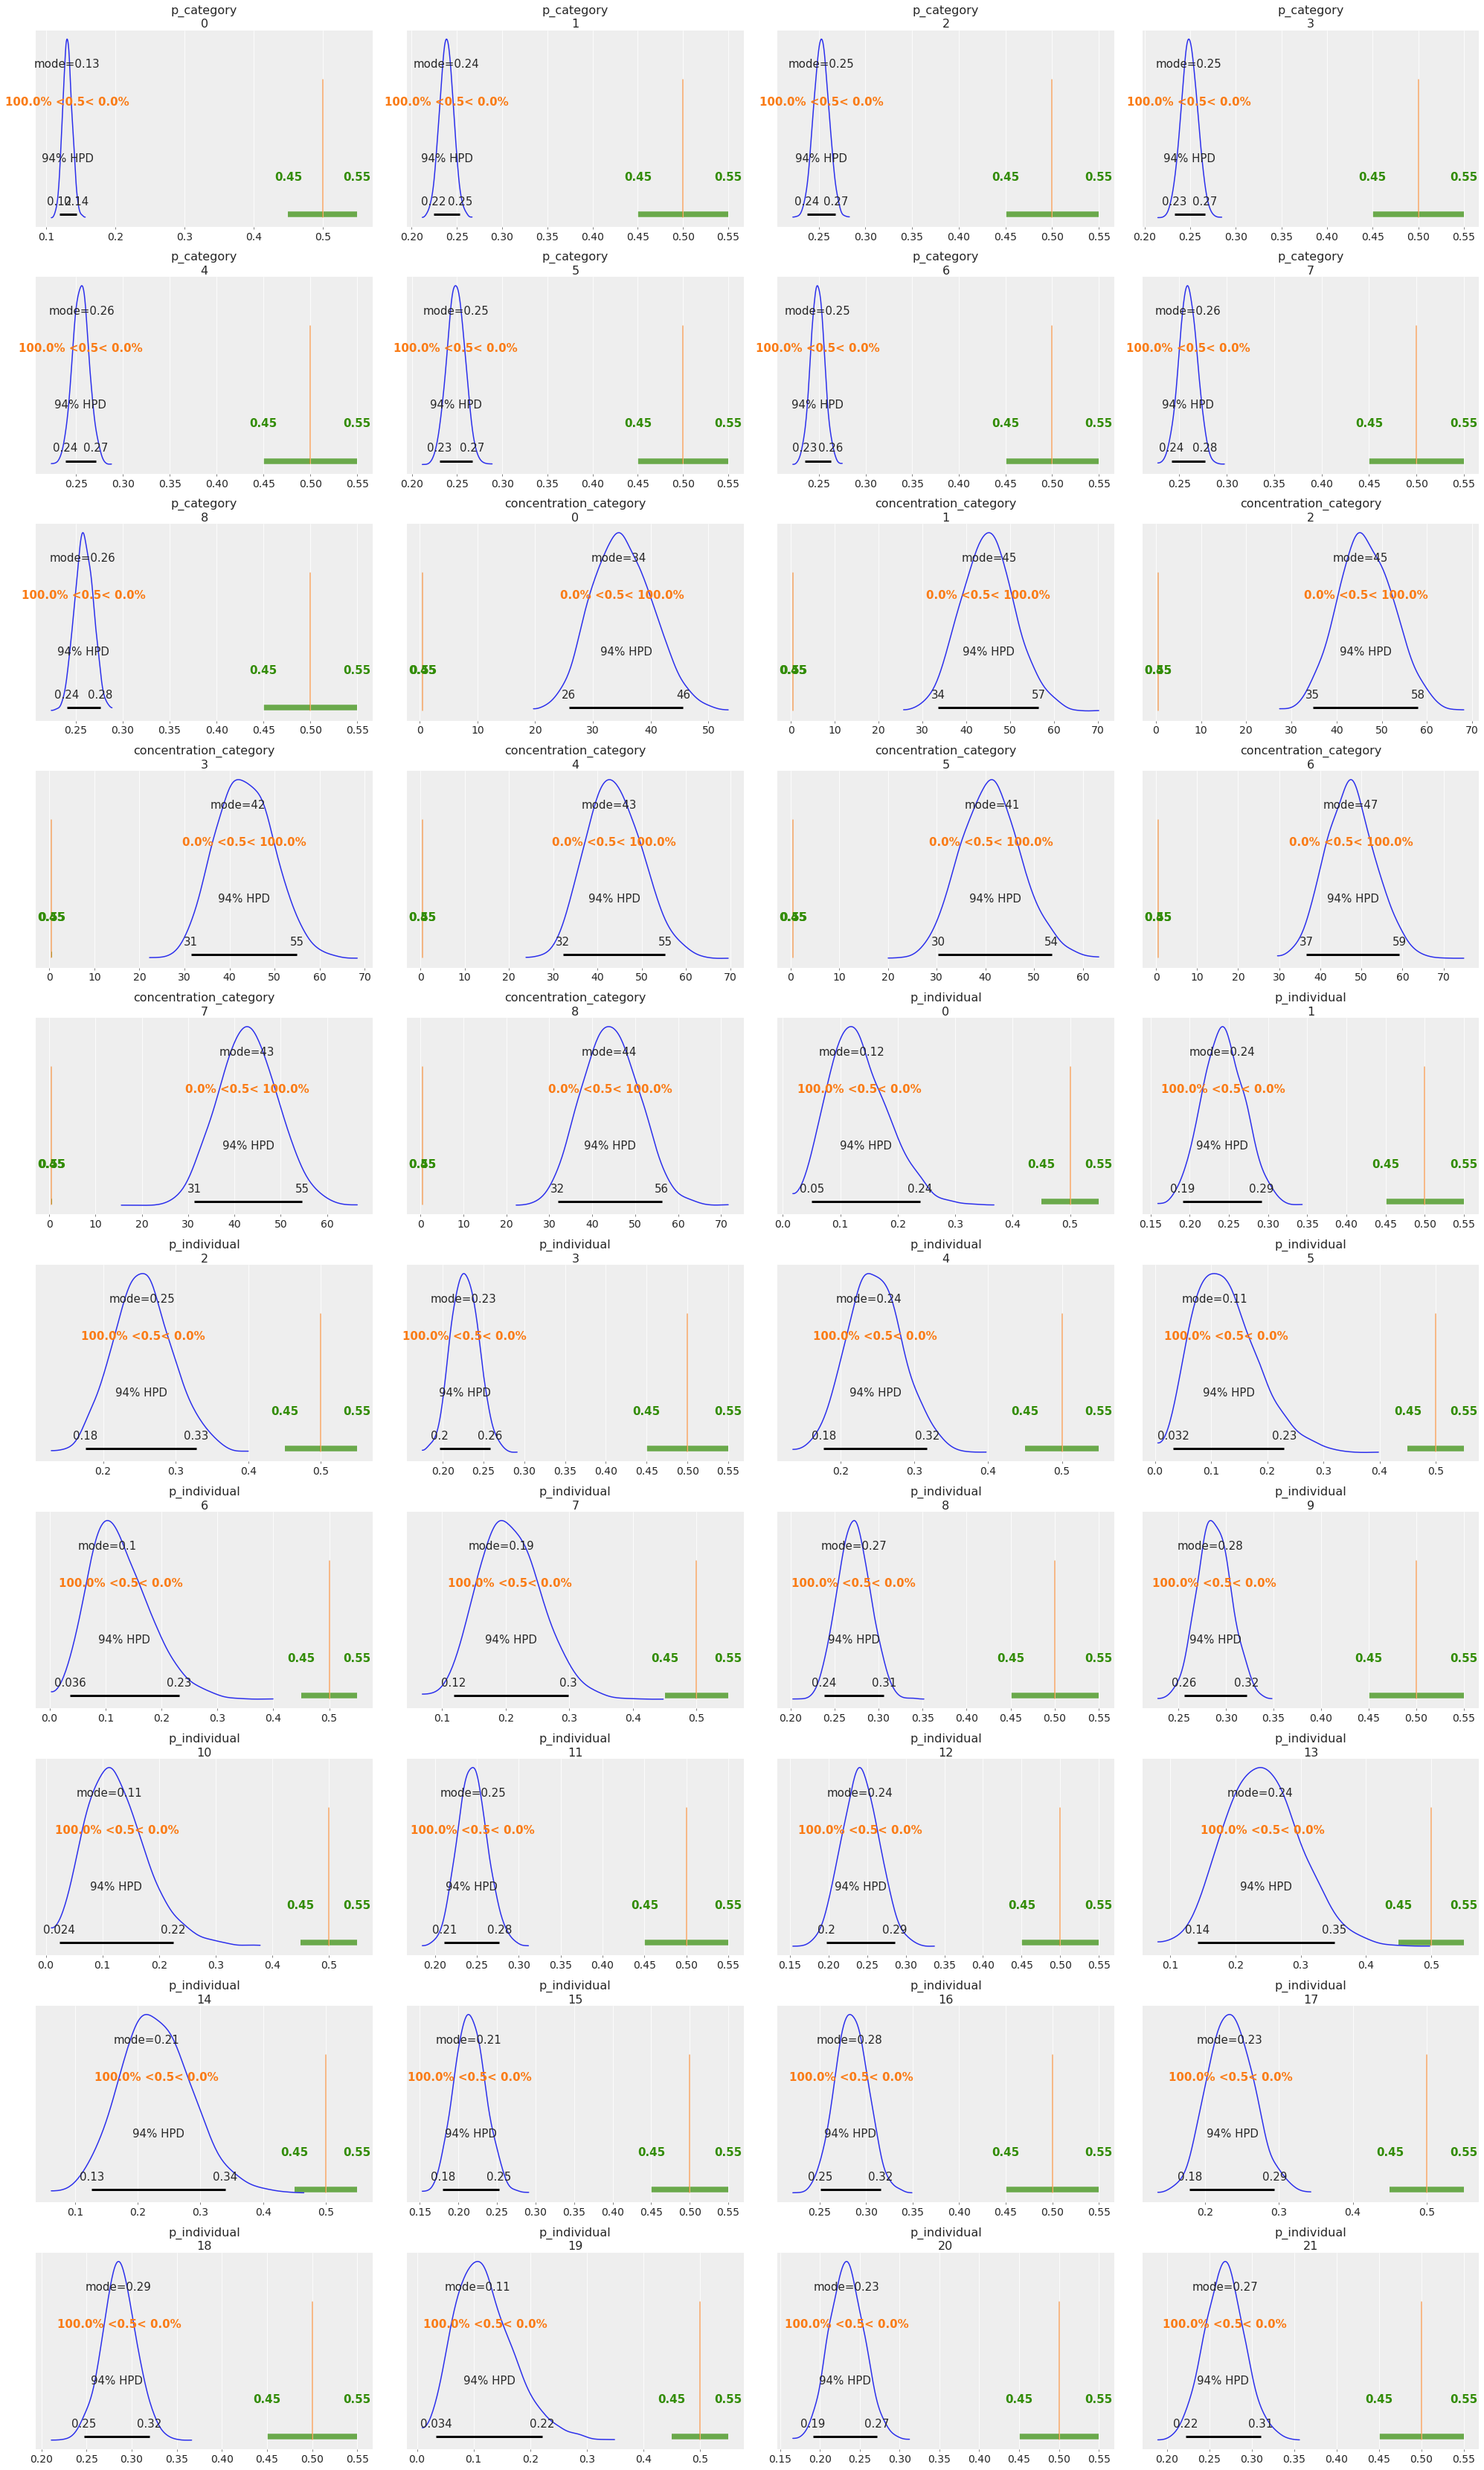

In [13]:
with pm.Model() as model_h:
  p_category = pm.Beta('p_category', 1, 1, shape=num_categories)
  concentration_category = pm.HalfNormal('concentration_category', 10, shape=num_categories)

  p_individual = pm.Beta('p_individual',
                       alpha=p_category[category_id]*concentration_category[category_id],
                       beta=(1.0-p_category[category_id])*concentration_category[category_id],
                       shape=num_individuals)
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_h = pm.sample(2000, random_seed=123)
  print(az.summary(trace_h))
  pm.traceplot(trace_h)
  az.plot_posterior(trace_h, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h)

## Heirarchy with Overall

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual, concentration_category, p_category, concentration_overall, p_overall]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [01:02<00:00, 39.76it/s]
The number of effective samples is smaller than 25% for some parameters.


                         mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_overall               0.251  0.034   0.191  ...    6122.0    2935.0    1.0
concentration_overall  19.500  6.383   7.557  ...    4856.0    2292.0    1.0
p_category[0]           0.131  0.007   0.118  ...    1014.0    1546.0    1.0
p_category[1]           0.238  0.008   0.224  ...    3867.0    3083.0    1.0
p_category[2]           0.252  0.008   0.237  ...    4938.0    3010.0    1.0
...                       ...    ...     ...  ...       ...       ...    ...
p_individual[943]       0.144  0.058   0.046  ...    4853.0    2319.0    1.0
p_individual[944]       0.281  0.018   0.245  ...    6417.0    2691.0    1.0
p_individual[945]       0.169  0.038   0.104  ...    6345.0    2501.0    1.0
p_individual[946]       0.097  0.032   0.044  ...    7142.0    2000.0    1.0
p_individual[947]       0.269  0.018   0.236  ...    5455.0    2752.0    1.0

[968 rows x 11 columns]


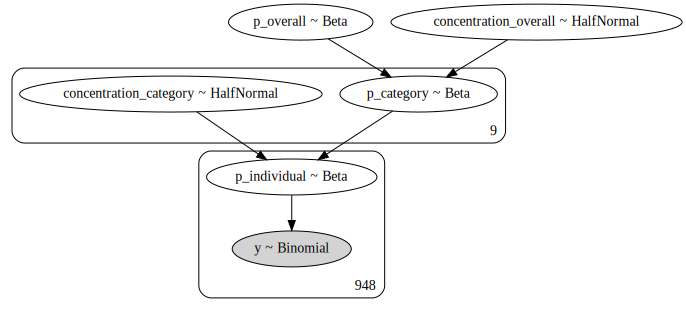

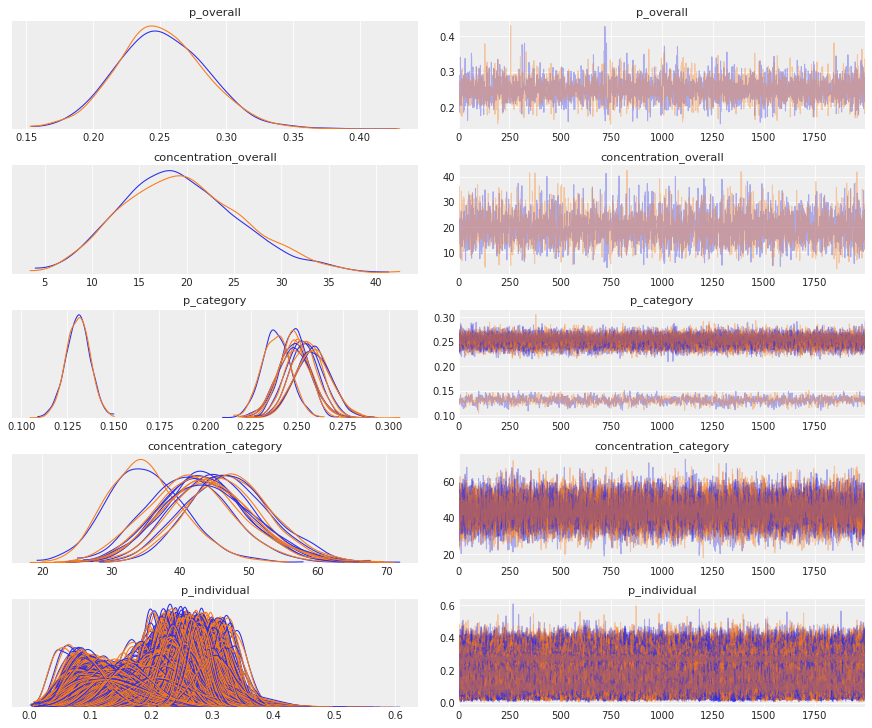

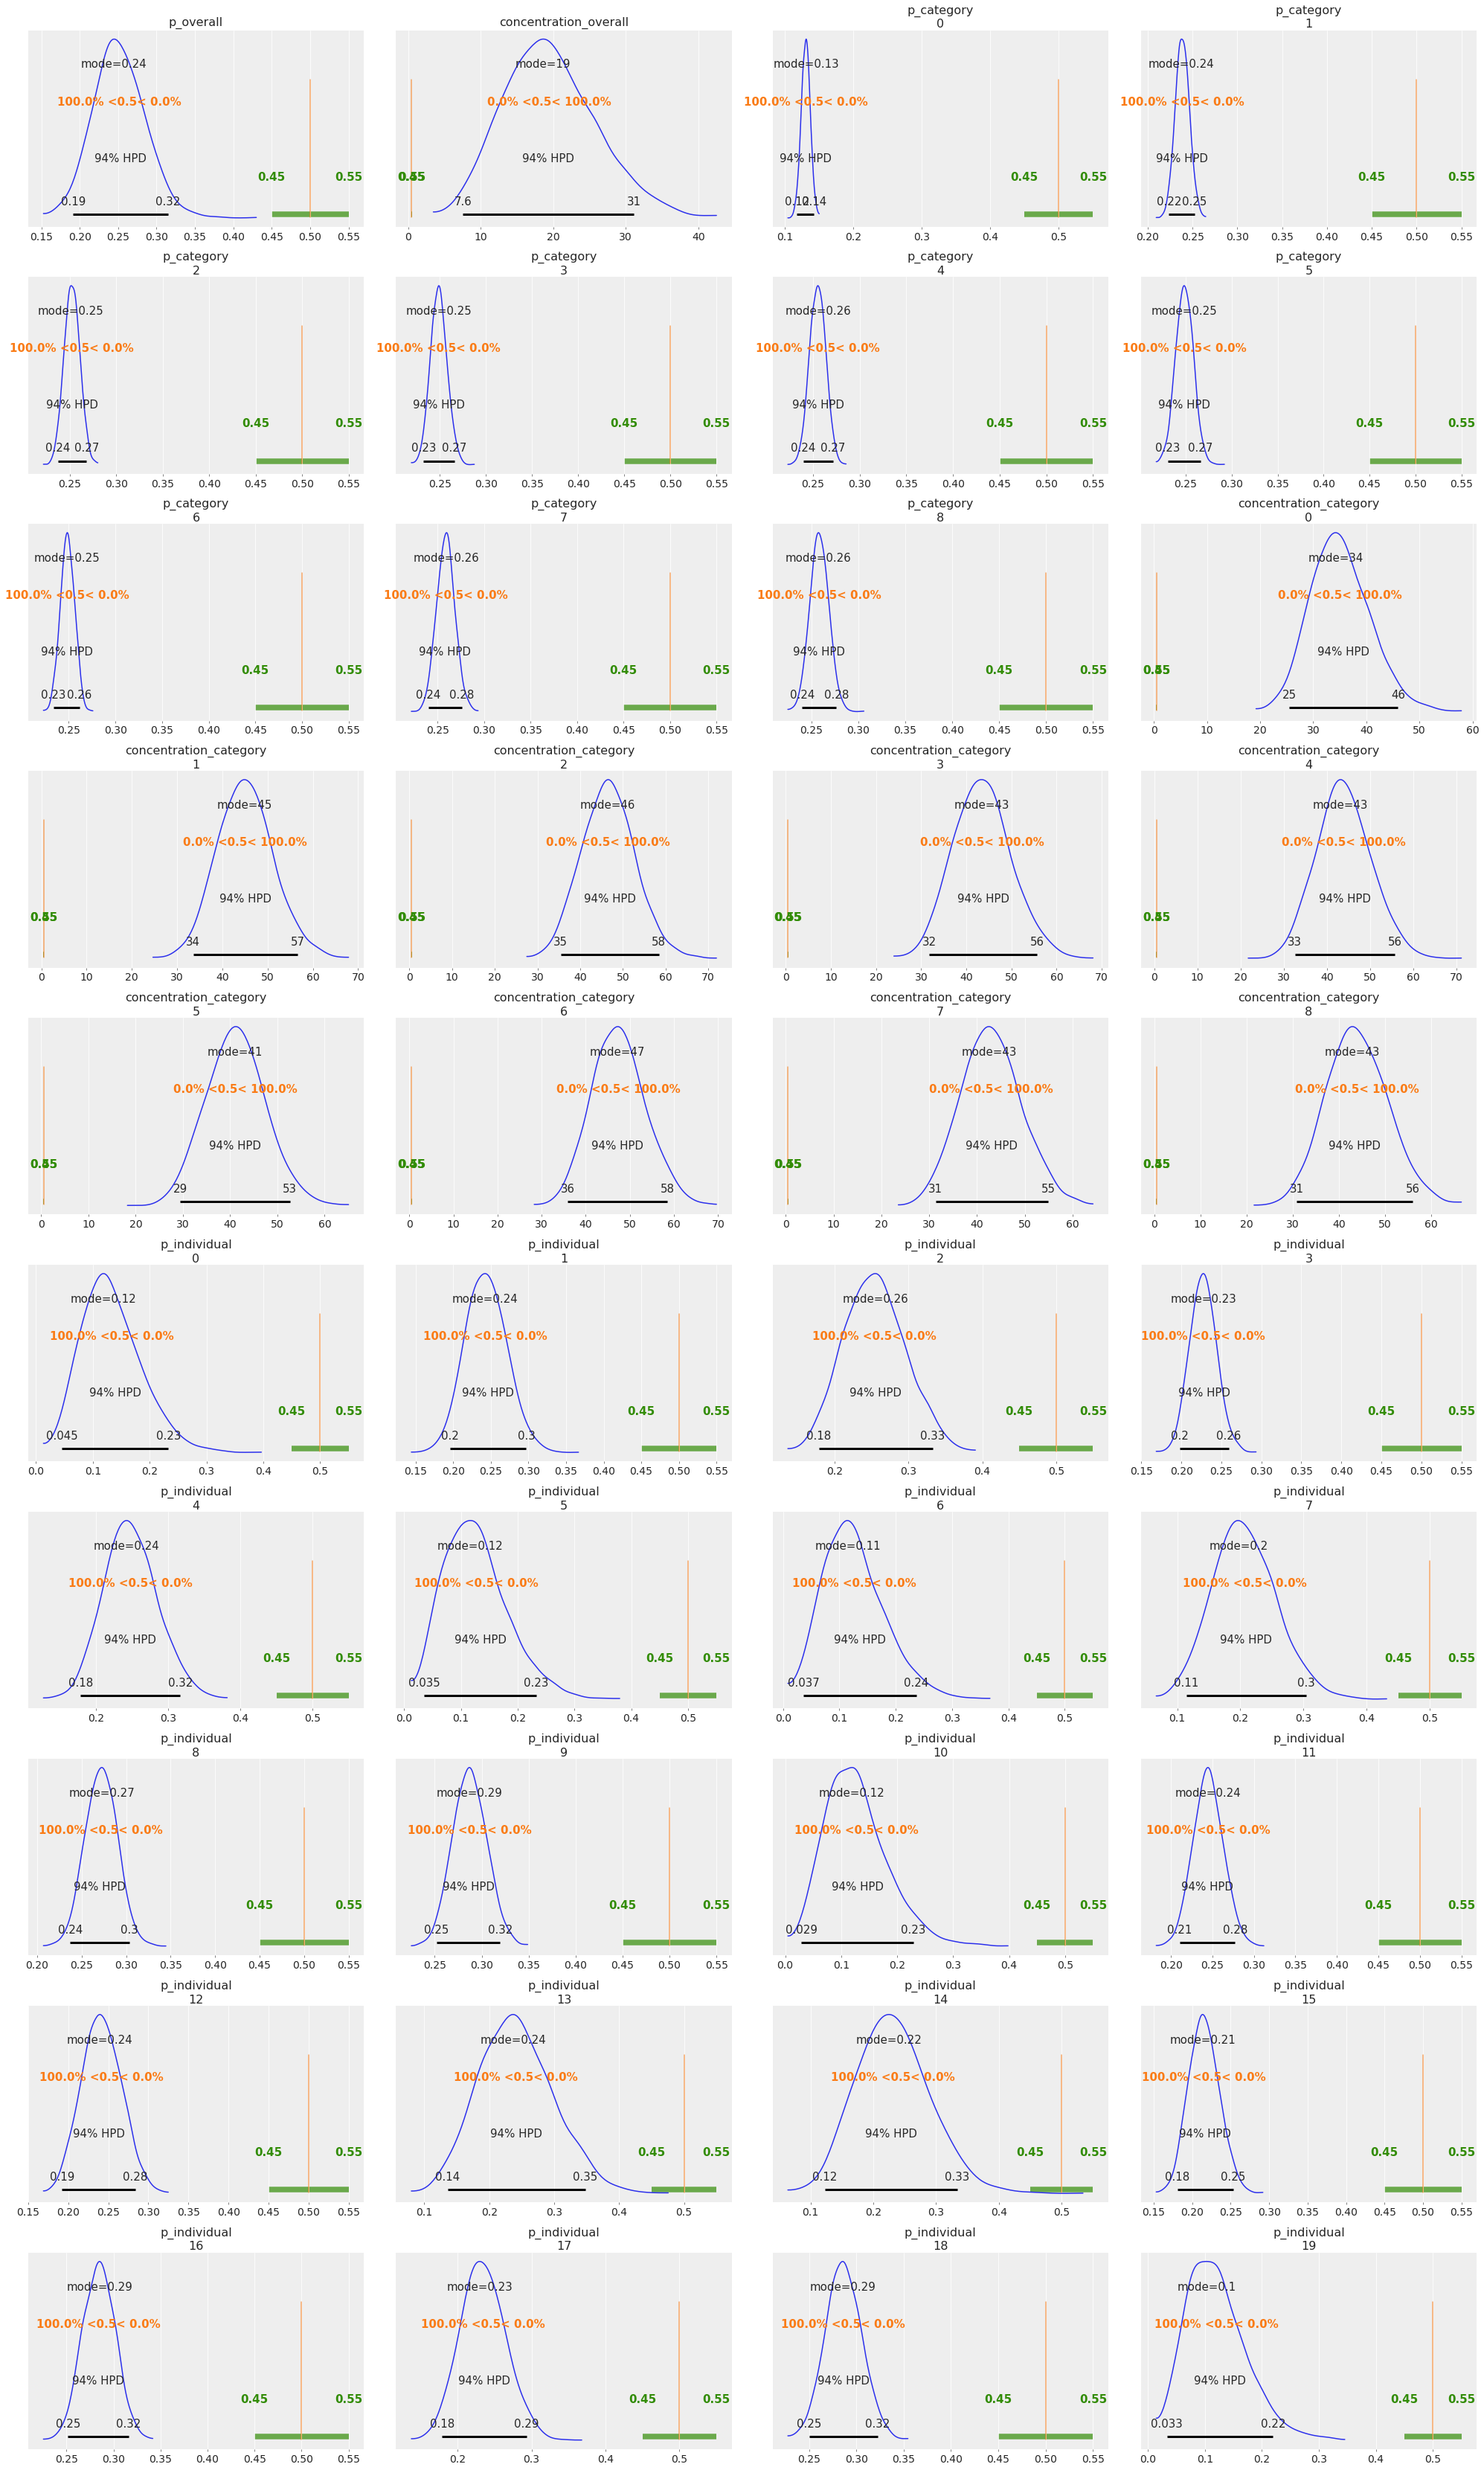

In [14]:
with pm.Model() as model_h_o:
  p_overall = pm.Beta('p_overall', 1, 1)
  concentration_overall = pm.HalfNormal('concentration_overall', 10)

  
  p_category = pm.Beta('p_category',
                       alpha=p_overall*concentration_overall,
                       beta=(1.0-p_overall)*concentration_overall,
                       shape=num_categories)
  concentration_category = pm.HalfNormal('concentration_category', 10, shape=num_categories)

  p_individual = pm.Beta('p_individual',
                       alpha=p_category[category_id]*concentration_category[category_id],
                       beta=(1.0-p_category[category_id])*concentration_category[category_id],
                       shape=num_individuals)
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_h_o = pm.sample(2000, random_seed=123)
  print(az.summary(trace_h_o))
  pm.traceplot(trace_h_o)
  az.plot_posterior(trace_h_o, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h_o)